## Table of Contents
* [Introduction](#introduction)

<a id='introduction'></a>
### Introduction
This notebook describes how to value storage using the Least Squares Monte Carlo multi-factor valuation model using the Python API. As a prerequisite please first study the notebook [creating_storage_instances](creating_storage_instances.ipynb) which describes how to create instances of CmdtyStorage which represent the storage facility.



In [15]:
# Common Imports
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value, multi_factor_value
import pandas as pd

#### Storage Object
For all examples the following storage with ratchets is used.

In [4]:
storage = CmdtyStorage(
    freq='D',
    storage_start = '2021-04-01',
    storage_end = '2022-04-01',
    injection_cost = 0.01,
    withdrawal_cost = 0.025,
    constraints= [
                ('2021-04-01', # For days after 2021-04-01 (inclusive) until 2022-10-01 (exclusive):
                       [
                            (0.0, -150.0, 250.0),    # At min inventory of zero, max withdrawal of 150, max injection 250
                            (2000.0, -200.0, 175.0), # At inventory of 2000, max withdrawal of 200, max injection 175
                            (5000.0, -260.0, 155.0), # At inventory of 5000, max withdrawal of 260, max injection 155
                            (7000.0, -275.0, 132.0), # At max inventory of 7000, max withdrawal of 275, max injection 132
                        ]),
                  ('2022-10-01', # For days after 2022-10-01 (inclusive):
                       [
                            (0.0, -130.0, 260.0),    # At min inventory of zero, max withdrawal of 130, max injection 260
                            (2000.0, -190.0, 190.0), # At inventory of 2000, max withdrawal of 190, max injection 190
                            (5000.0, -230.0, 165.0), # At inventory of 5000, max withdrawal of 230, max injection 165
                            (7000.0, -245.0, 148.0), # At max inventory of 7000, max withdrawal of 245, max injection 148
                        ]),
                 ]
)

#### Forward Curve
The following natural gas forward curve is used in all examples. This is a monthly curve, converted to daily granularity with piecewise flat interpolation. To create smooth daily curves, with day-of-week seasonality see [Cmdty Curves](https://github.com/cmdty/curves).

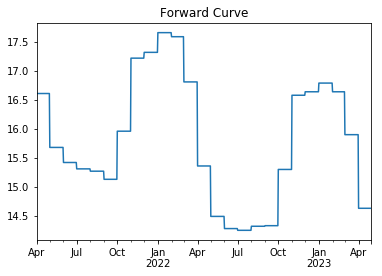

In [20]:
monthly_index = pd.period_range(start='2021-04-25', periods=25, freq='M')
monthly_fwd_prices = [16.61, 15.68, 15.42, 15.31, 15.27, 15.13, 15.96, 17.22, 17.32, 17.66, 
                      17.59, 16.81, 15.36, 14.49, 14.28, 14.25, 14.32, 14.33, 15.30, 16.58, 
                      16.64, 16.79, 16.64, 15.90, 14.63]
fwd_curve = pd.Series(data=monthly_fwd_prices, index=monthly_index).resample('D').fillna('pad')
%matplotlib inline
fwd_curve.plot(title='Forward Curve')

#### Interest Rates Curve
Act/365 continuously compounded interest rates are provided as a Pandas Series instance. In these examples, for simplicity a linearly interpolated rates curve is used. 

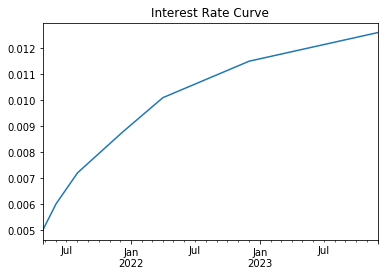

In [29]:
rates = [0.005, 0.006, 0.0072, 0.0087, 0.0101, 0.0115, 0.0126]
rates_pillars = pd.PeriodIndex(freq='D', data=['2021-04-25', '2021-06-01', '2021-08-01', '2021-12-01', '2022-04-01', 
                                              '2022-12-01', '2023-12-01'])
ir_curve = pd.Series(data=rates, index=rates_pillars).resample('D').asfreq('D').interpolate(method='linear')
ir_curve.plot(title='Interest Rate Curve')

<a id='three_factor_seasonal'></a>
### Three Factor Seasonal Model
This section gives an example of using the storage valuation model where the commodity price dynamics are assumed to follow a three-factor seasonal model. The stochastic price model is described in [this paper](https://github.com/cmdty/core/blob/master/docs/three_factor_seasonal_model/three_factor_seasonal_model.pdf), which is a special case of the more general [multi-factor model](https://github.com/cmdty/core/blob/master/docs/multifactor_price_process/multifactor_price_process.pdf). The three factor model is particularly suited power and natural gas which show seaonality in the volatility and correlation.

In [32]:
three_factor_results = three_factor_seasonal_value(
    cmdty_storage = storage,
    val_date = '2021-04-25',
    inventory = 1500.0,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = lambda decision_date: decision_date.asfreq('M').asfreq('D', 'end') + 20,
    spot_mean_reversion = 45.0,
    spot_vol = 0.65,
    long_term_vol = 0.21,
    seasonal_vol = 0.18,
    num_sims = 500,
    basis_funcs = '1 + x_st + x_sw + x_lt + x_st**2 + x_sw**2 + x_lt**2 + x_st**3 + x_sw**3 + x_lt**3',
    discount_deltas=True
)